In [103]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
pd.options.mode.copy_on_write = True



# Heart Disease Prediction

## Summary

This project is was designed around the usage of common health observations associated with heart disease. We will initially explore the data before using a commonly available machine learning model called **K Nearest Neighbor** to predict patients with high risk of heart disease. 

## Data Set

This is a publicly available dataset found on kaggle [here](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction).

### Data Set Legend

**Age** - The age of the individual in years.

**Sex** - The sex of the individual. Male or Female.

**ChestPainType** - Pain defined by the source. "ASY" typically refers to angina (chest pain caused by reduced blood flow to the heart). "NAP" is for pain caused by not directly linked to activity, such as acid reflux or muscle strain.

**RestingBP** - The resting blood pressure of the individual.

**Cholesterol** - The serum measurement. Commonly referred to as the "total cholesterol". 

**fastingBS** - Blood sugar measured in mg/dL. Fasting blood sugar must be measured after at least eigh hours of fasting.

**RestingECG** - ECG measurements when the individual is at rest, typically in a comfortable lying down position.

**MaxHR** - The maximum heart rate measured by an individual under strenuous activity such as interval exercise.

**ExerciseAngina** - Chest pain that occurs when the heart muscle is strained during exercise.

**Oldpeak** - A value in ECG that measures the depression in the ST segment caused by exercise relative to rest.

**ST_Slope** - The slope of the peak exercise ST segment during an ECG.

**HeartDisease** - If the individual has heart disease. Either "yes" (1) or "no" (0). This is the target variable for our machine learning.

In [104]:
df = pd.read_csv("heart_disease_prediction.csv")


After reading in the data we can see that the column names are not normalized. This should be done for easy use in the future as we work with different features. We use column string replacements with RegEx to normalize with python standards for underscores between words.

In [105]:
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [106]:
df.columns = (
    df.columns
    .str.replace(r'(?<=[a-z])(?=[A-Z])', '_', regex=True)  # Add underscore between lowercase and uppercase letters
    .str.replace(r'(?<=[A-Z])(?=[A-Z][a-z])', '_', regex=True)  # Add underscore between consecutive capitals followed by lowercase
    .str.lower()  # Convert to lowercase
)

Now that the columns are updated, we can begin to view the data. Let's find out some basic statistics about each feature and see what data engineering is required for the data set. 

### Initial View

The data reflects marginally skewed in some features such as Age, Resting BP, and Max HR. Some of the features are encoded so the mean and median are less helpful. We can see that a skew is apparent with Fasting BS with the quartile ranges reflecting over 75% of values are 0. We can either assume that the data was marked zero to fill nulls previously or fasting blood sugar tests were not sampled equally.

We have:
* 5 object types (*sex*, *chest_pain_type*, *resting_ecg*, *exercise_angina*, and *st_slope*)
* 6 whole number (integer) types (*age*, *resting_bp*, *cholesterol*, *fasting_bs*, *max_hr*, *heart_disease*)
* 1 float (*old_peak*)



**Concerns about Data**

We see that the *serum cholesterol* feature has a minimum of 0, which would be an extremely unheard of medical case. We can infer this means that we have records where cholesterol was improperly measured or nulls were previously filled with zeroes. When filtering the data out, we see that approximately 19% of the total sample is missing a cholesterol value. This is too large of a pool of records to simply drop. We will need to investigate the values and potentially compute the median values to insert them.

We see the same issue with resting blood pressure, this must be addressed before moving to training data. 




In [107]:
df.dtypes

age                  int64
sex                 object
chest_pain_type     object
resting_bp           int64
cholesterol          int64
fasting_bs           int64
resting_ecg         object
max_hr               int64
exercise_angina     object
oldpeak            float64
st_slope            object
heart_disease        int64
dtype: object

In [108]:
df.describe()

,age,resting_bp,cholesterol,fasting_bs,max_hr,oldpeak,heart_disease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [109]:
df.loc[df['cholesterol'] == 0]

,age,sex,chest_pain_type,resting_bp,cholesterol,fasting_bs,resting_ecg,max_hr,exercise_angina,oldpeak,st_slope,heart_disease
293,65,M,ASY,115,0,0,Normal,93,Y,0.0,Flat,1
294,32,M,TA,95,0,1,Normal,127,N,0.7,Up,1
295,61,M,ASY,105,0,1,Normal,110,Y,1.5,Up,1
296,50,M,ASY,145,0,1,Normal,139,Y,0.7,Flat,1
297,57,M,ASY,110,0,1,ST,131,Y,1.4,Up,1
...,...,...,...,...,...,...,...,...,...,...,...,...
514,43,M,ASY,122,0,0,Normal,120,N,0.5,Up,1
515,63,M,NAP,130,0,1,ST,160,N,3.0,Flat,0
518,48,M,NAP,102,0,1,ST,110,Y,1.0,Down,1
535,56,M,ASY,130,0,0,LVH,122,Y,1.0,Flat,1


### Object Data 

Are the categorical features equal or are they skewed?


Sex - Extreme skew towards males in the population. 

Chest Pain Type - Heavily skewed towards ASY angina.

Resting ecg - majority have normal category while ST and LVH are almost equal

Exercise angina - roughly 25% more N to Y

ST_Slop - Majority are flat with Up next. Down is extremely rare.

In [110]:
obj_dtypes = df.select_dtypes('object')

In [111]:
obj_dtypes

,sex,chest_pain_type,resting_ecg,exercise_angina,st_slope
0,M,ATA,Normal,N,Up
1,F,NAP,Normal,N,Flat
2,M,ATA,ST,N,Up
3,F,ASY,Normal,Y,Flat
4,M,NAP,Normal,N,Up
...,...,...,...,...,...
913,M,TA,Normal,N,Flat
914,M,ASY,Normal,N,Flat
915,M,ASY,Normal,Y,Flat
916,F,ATA,LVH,N,Flat


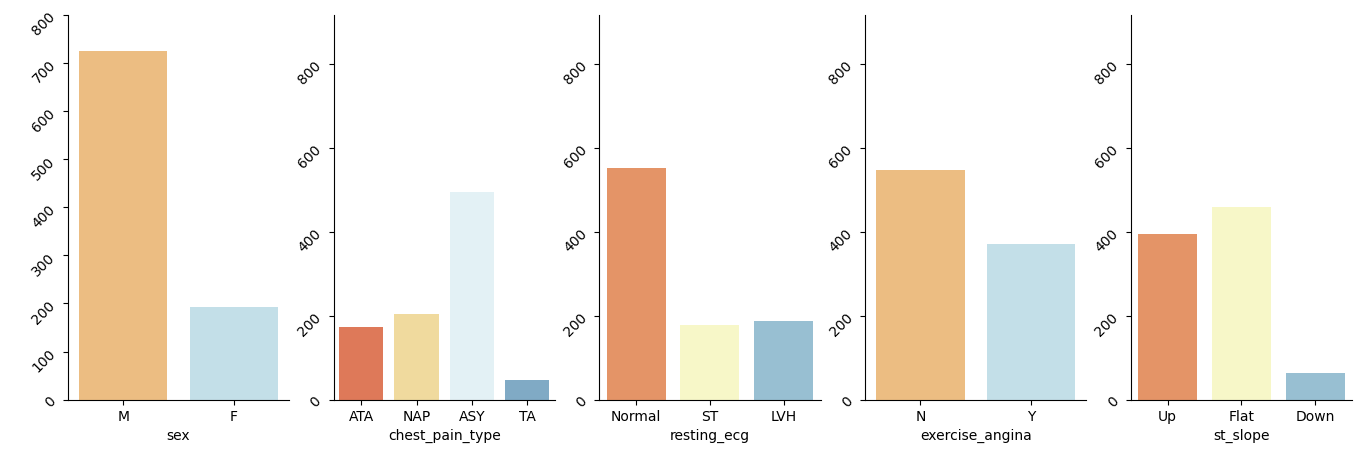

In [40]:
plt.figure(constrained_layout=False, figsize=(20, 5))

# 2 rows, 3 columns per

# 1st row
ax1 = plt.subplot(1, 6, 1)
plt.yticks(rotation=45)
plt.ylabel(ylabel=' ')
plt.ylim(0, obj_dtypes.shape[0])
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
sns.countplot(obj_dtypes,x='sex',hue='sex',palette='RdYlBu')

ax2 = plt.subplot(1, 6, 2)
plt.yticks(rotation=45)
plt.ylabel(ylabel=' ')
plt.ylim(0, obj_dtypes.shape[0])
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
sns.countplot(obj_dtypes,x='chest_pain_type',hue='chest_pain_type',palette='RdYlBu')

# 2nd row
ax3 = plt.subplot(1, 6, 3)
plt.yticks(rotation=45)
plt.ylabel(ylabel=' ')
plt.ylim(0, obj_dtypes.shape[0])
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
sns.countplot(obj_dtypes,x='resting_ecg',hue='resting_ecg',palette='RdYlBu')

ax4 = plt.subplot(1, 6, 4)
plt.yticks(rotation=45)
plt.ylabel(ylabel=' ')
plt.ylim(0, obj_dtypes.shape[0])
ax4.spines['top'].set_visible(False)
ax4.spines['right'].set_visible(False)
sns.countplot(obj_dtypes,x='exercise_angina',hue='exercise_angina',palette='RdYlBu')

ax5 = plt.subplot(1, 6, 5)
plt.yticks(rotation=45)
plt.ylabel(ylabel=' ')
plt.ylim(0, obj_dtypes.shape[0])
ax5.spines['top'].set_visible(False)
ax5.spines['right'].set_visible(False)
sns.countplot(obj_dtypes,x='st_slope',hue='st_slope',palette='RdYlBu')

plt.show()




### Updating Cholesterol and Resting BP

Cholesterol is a well-known factor related to heart disease. We can use this to factor in our median values for each missing record. Men and women have slightly different recommendations for cholesterol levels as per [mayo clinic](https://www.mayoclinichealthsystem.org/hometown-health/speaking-of-health/know-your-numbers-cholesterol). We will differentiate the sexes and whether or not the individual has heart disease. Before we make any changes we should review the data and cholesterol to compare if there are any significant impacts between the sexes after imputation.

<Axes: xlabel='sex', ylabel='cholesterol'>

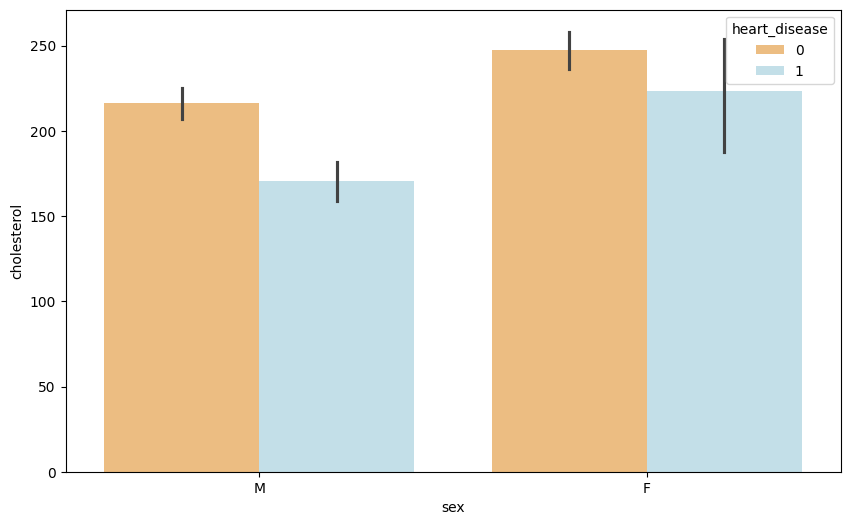

In [113]:
plt.figure(constrained_layout=False, figsize=(10, 6))


sns.barplot(data=df,x='sex',hue='heart_disease',y=df['cholesterol'],palette='RdYlBu')


We can see that women on average have a higher level of cholesterol, however, the data is heavily skewed towards males in our dataset. We can see the level of variability for females is very high due to the missing values and outliers. For comparisons sake, we will keep a copy of the original dataframe for side-by-side comparison. Below we isolate each datapoint based on: 
1. Sex and No Heart Disease
2. Sex and Heart Disease

The median is used for each respect group and added to the original dataframe. A side by side graph shows a large improvement in our female population for cholesterol variability. In addition both sexes show that heart disease positive individuals now reflect a higher cholesterol on average for heart disease positive individuals.

In [114]:
old_df = df.copy()


# Male patients with heart disease have cholesterol level of 0
male_median_heart_disease = np.int64(df.loc[
    (df['cholesterol'] != 0) & (df['sex'] == 'M') & (df['heart_disease'] == 1),
    'cholesterol'
].median())

df.loc[
    (df['cholesterol'] == 0) & (df['sex'] == 'M') & (df['heart_disease'] == 1),
    'cholesterol'
] = male_median_heart_disease

# Male patients without heart disease
male_median_no_heart_disease = np.int64(df.loc[
    (df['cholesterol'] != 0) & (df['sex'] == 'M') & (df['heart_disease'] == 0),
    'cholesterol'
].median())

df.loc[
    (df['cholesterol'] == 0) & (df['sex'] == 'M') & (df['heart_disease'] == 0),
    'cholesterol'
] = male_median_no_heart_disease

# Female patients with heart disease
female_median_heart_disease = np.int64(df.loc[
    (df['cholesterol'] != 0) & (df['sex'] == 'F') & (df['heart_disease'] == 1),
    'cholesterol'
].median())

df.loc[
    (df['cholesterol'] == 0) & (df['sex'] == 'F') & (df['heart_disease'] == 1),
    'cholesterol'
] = female_median_heart_disease

# Female patients without heart disease
female_median_no_heart_disease = np.int64(df.loc[
    (df['cholesterol'] != 0) & (df['sex'] == 'F') & (df['heart_disease'] == 0),
    'cholesterol'
].median())

df.loc[
    (df['cholesterol'] == 0) & (df['sex'] == 'F') & (df['heart_disease'] == 0),
    'cholesterol'
] = female_median_no_heart_disease


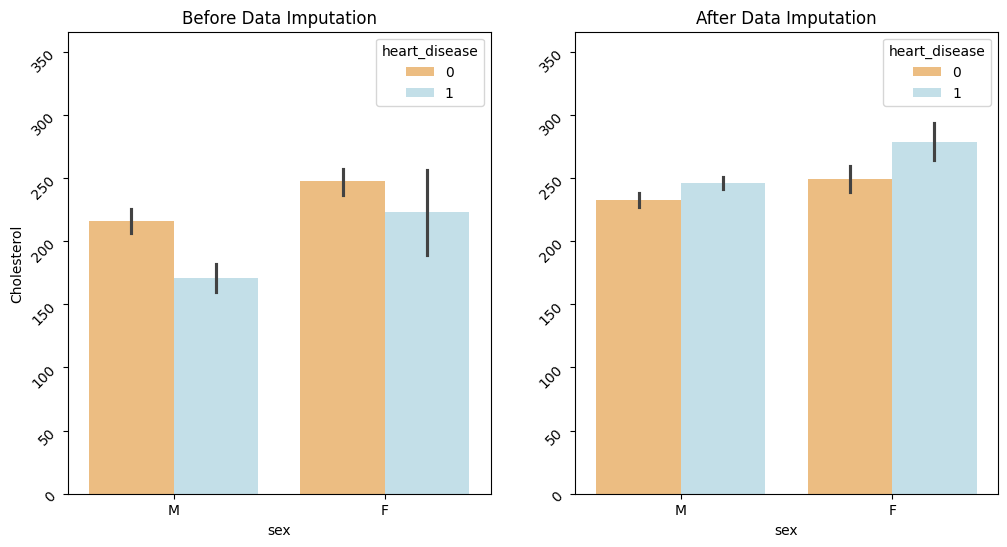

In [115]:
ymax = np.int64(df['cholesterol'].mean() * 1.5) # Abritrary value for ceiling


plt.figure(constrained_layout=False, figsize=(12, 6))

# Before Data Imputation
plt.subplot(1, 2, 1)
plt.yticks(rotation=45)
plt.ylabel(ylabel='Cholesterol')
plt.ylim(0, ymax)
plt.title('Before Data Imputation')
# plt.axline(old_df['cholesterol'].mean(),0, color='red')
sns.barplot(old_df,x='sex',hue='heart_disease',y=old_df['cholesterol'],palette='RdYlBu')

# After Data Imputation
plt.subplot(1, 2, 2)
plt.yticks(rotation=45)
plt.ylabel(ylabel='Cholesterol')
plt.ylim(0, ymax)
plt.title('After Data Imputation')
# plt.axline(df['cholesterol'].mean(),0, color='red')
plt.ylabel(ylabel=' ')
sns.barplot(df,x='sex',hue='heart_disease',y=df['cholesterol'],palette='RdYlBu')

plt.show()


In [ ]:
# Male patients with heart disease have resting blood pressure level of 0
male_median_heart_disease = np.int64(df.loc[
    (df['resting_bp'] != 0) & (df['sex'] == 'M') & (df['heart_disease'] == 1),
    'resting_bp'
].median())

df.loc[
    (df['resting_bp'] == 0) & (df['sex'] == 'M') & (df['heart_disease'] == 1),
    'resting_bp'
] = male_median_heart_disease

# Male patients without heart disease
male_median_no_heart_disease = np.int64(df.loc[
    (df['resting_bp'] != 0) & (df['sex'] == 'M') & (df['heart_disease'] == 0),
    'resting_bp'
].median())

df.loc[
    (df['resting_bp'] == 0) & (df['sex'] == 'M') & (df['heart_disease'] == 0),
    'resting_bp'
] = male_median_no_heart_disease

# Female patients with heart disease
female_median_heart_disease = np.int64(df.loc[
    (df['resting_bp'] != 0) & (df['sex'] == 'F') & (df['heart_disease'] == 1),
    'resting_bp'
].median())

df.loc[
    (df['resting_bp'] == 0) & (df['sex'] == 'F') & (df['heart_disease'] == 1),
    'resting_bp'
] = female_median_heart_disease

# Female patients without heart disease
female_median_no_heart_disease = np.int64(df.loc[
    (df['resting_bp'] != 0) & (df['sex'] == 'F') & (df['heart_disease'] == 0),
    'resting_bp'
].median())

df.loc[
    (df['resting_bp'] == 0) & (df['sex'] == 'F') & (df['heart_disease'] == 0),
    'resting_bp'
] = female_median_no_heart_disease